In [1]:
import pandas as pd
import numpy  as np
from scipy.misc import imresize
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models     import Sequential
from keras.layers     import Dense, Dropout, Activation, Flatten
from keras.layers     import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
import keras


from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(0)

In [3]:
TRAIN_PATH = "../../../../data/wiki_folds/age/train_1.csv"
VALID_PATH = "../../../../data/wiki_folds/age/valid_1.csv"
IMG_PATH  = "../../../../data/wiki/%s"

IMG_WIDTH  = 150
IMG_HEIGHT = 150
IMG_DIMS = (IMG_WIDTH, IMG_HEIGHT)

In [4]:
train = pd.read_csv(TRAIN_PATH)
valid = pd.read_csv(VALID_PATH)

train = train[["full_path","gender","age"]]
valid = valid[["full_path","gender","age"]]

In [5]:
train.head()

,full_path,gender,age
0,57/33135157_1995-06-05_2013.jpg,0.0,18
1,35/6123935_1952-07-21_2007.jpg,1.0,55
2,69/445169_1986-03-03_2006.jpg,0.0,20
3,46/3963146_1974-07-16_2004.jpg,0.0,30
4,65/3058665_1924-10-14_1966.jpg,1.0,42


In [6]:
valid.head()

,full_path,gender,age
0,65/40839965_1975-03-07_2013.jpg,1.0,38
1,48/26219548_1931-10-23_2009.jpg,1.0,78
2,62/543262_1934-11-13_2008.jpg,1.0,74
3,68/4554668_1980-08-04_2013.jpg,1.0,33
4,88/9288_1935-01-08_1957.jpg,1.0,22


In [7]:
true_path = lambda x: IMG_PATH % x
train["full_path"] = train["full_path"].apply(lambda x: true_path(x))
valid["full_path"] = valid["full_path"].apply(lambda x: true_path(x))

In [8]:
def get_image(x):
    try:
        val = img_to_array(imresize(load_img(x),IMG_DIMS))
    except:
        val = "ERR"
    return val

def generate_data(df):
    while True:
        size = 200
        data = df.sample(frac=1).reset_index(drop=True)
        sample  = data.ix[range(32)]
        sample.reset_index(inplace=True)
        
        sample["new_path"] = sample["full_path"].apply( lambda x:get_image(x))
        sample = sample[sample["new_path"] != "ERR"]
        sample.reset_index(inplace=True)
        
        X = sample
        X = X["new_path"].apply(lambda x: x.reshape((1,)+ x.shape))
        X = np.vstack(X)
        
        Y = sample["age"].as_matrix()
        yield (X,Y)

In [9]:
train_generator = generate_data(train)
valid_generator = generate_data(valid)

In [10]:
# Building a vainilla CNN
vainilla_cnn = Sequential()
vainilla_cnn.add(Convolution2D(32, 3, 3, input_shape=(IMG_WIDTH,IMG_HEIGHT,3), name='conv1_1'))
vainilla_cnn.add(Activation('relu'))
vainilla_cnn.add(MaxPooling2D(pool_size=(2, 2)))
vainilla_cnn.add(Dropout(0.25))

vainilla_cnn.add(Convolution2D(64, 3, 3))
vainilla_cnn.add(Activation('relu'))

vainilla_cnn.add(Convolution2D(32, 3, 3))
vainilla_cnn.add(Activation('relu'))

vainilla_cnn.add(Convolution2D(15, 3, 3))
vainilla_cnn.add(Activation('relu'))
vainilla_cnn.add(MaxPooling2D(pool_size=(2, 2)))
vainilla_cnn.add(Dropout(0.5))

vainilla_cnn.add(Flatten())
vainilla_cnn.add(Dense(output_dim=1200))
vainilla_cnn.add(Dropout(0.25))
vainilla_cnn.add(BatchNormalization())
vainilla_cnn.add(Activation("relu"))
vainilla_cnn.add(Dense(output_dim=100, input_dim=600))
vainilla_cnn.add(BatchNormalization())
vainilla_cnn.add(Activation("relu"))
vainilla_cnn.add(Dense(output_dim=100, input_dim=300))
vainilla_cnn.add(BatchNormalization())
vainilla_cnn.add(Activation("relu"))
vainilla_cnn.add(Dense(output_dim=100, input_dim=200))
vainilla_cnn.add(BatchNormalization())
vainilla_cnn.add(Activation("relu"))
vainilla_cnn.add(Dropout(0.5))
vainilla_cnn.add(Dense(output_dim=1))

In [11]:
# Compile
vainilla_cnn.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])

In [12]:
# Train
history = vainilla_cnn.fit_generator(train_generator, 
                           validation_data=valid_generator,
                           nb_val_samples=200,
                           samples_per_epoch=200, 
                           nb_epoch=200)

Epoch 1/200


/usr/local/lib/python2.7/dist-packages/pandas/core/ops.py:739: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = lib.scalar_compare(x, y, op)


192/200 [===========================>..] - ETA: 0s - loss: 1810.7761 - mean_squared_error: 1810.7761 

/usr/local/lib/python2.7/dist-packages/Keras-1.2.0-py2.7.egg/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


224/200 [=================================] - 7s - loss: 1816.9481 - mean_squared_error: 1816.9481 - val_loss: 3274.1536 - val_mean_squared_error: 3274.1536
Epoch 2/200
224/200 [=================================] - 2s - loss: 1762.9950 - mean_squared_error: 1762.9950 - val_loss: 2777.9155 - val_mean_squared_error: 2777.9155
Epoch 3/200
224/200 [=================================] - 3s - loss: 1578.2693 - mean_squared_error: 1578.2693 - val_loss: 1842.78

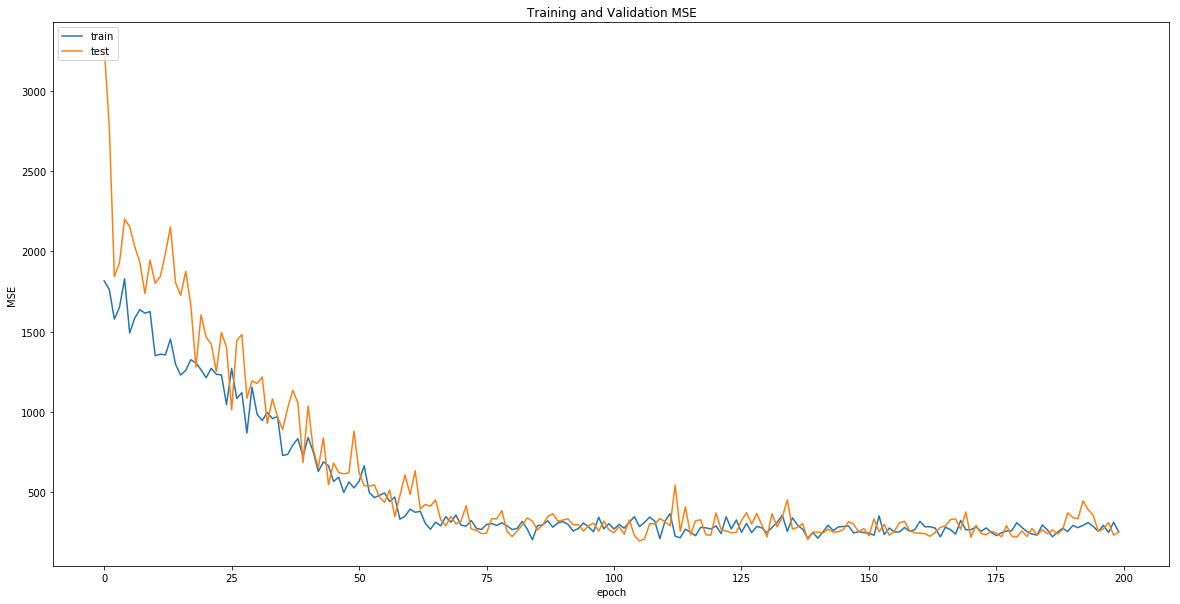

In [15]:
 # Plotting training accuracy and testing accuracy acros epochs
plt.figure(figsize=(20,10))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Training and Validation MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# serialize model to JSON
model_json = vainilla_cnn.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
vainilla_cnn.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
